In [ ]:
#default_exp core.train

In [ ]:
#export
import torch
from torch import nn
from torch.nn import functional as F
from vase.config import DATA_PATH, PARAM_PATH
from vase.core.utils import rec_likelihood, kl_div_stdnorm, euclidean


In [ ]:
#hide
from vase.core.models import FCEncoder, FCDecoder, Encoder, Decoder, PaperVanillaVAE, FCVAE, LatentMaskVAE, EnvInferVAE, GenReplayVAE
from vase.core.datasets.moving_mnist import MovingFashionMNIST, MovingMNIST, CommonMNIST, CommonFashionMNIST, FixedMNIST
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import os
from  datetime import datetime as dt

In [ ]:
train = False
latents=24
batch_size=64

In [ ]:
#hide
mnist_data = CommonMNIST(DATA_PATH, transform=ToTensor(), download=True)
fc_vae_helper = FCVAE(latents)
mnist_loader = DataLoader(mnist_data, batch_size=batch_size, shuffle=True)
mnist_batch, _ = iter(mnist_loader).next()
small_fashion = CommonFashionMNIST(DATA_PATH, transform=ToTensor())
sf_loader = DataLoader(small_fashion, batch_size=batch_size, shuffle=True)
sf_batch, _ = iter(sf_loader).next()
rec, mu, logvar = fc_vae_helper(mnist_batch)
fashion_data = MovingFashionMNIST(DATA_PATH, transform=ToTensor(), download=True)
fashion_loader = DataLoader(fashion_data, batch_size, shuffle=True)
fashion_batch, _, _ = iter(fashion_loader).next()
mm_data = MovingMNIST(DATA_PATH, transform=ToTensor(), download=True)
mm_loader = DataLoader(mm_data, batch_size, shuffle=True)
mm_batch, _, _ = iter(mm_loader).next()

# Training For VASE
> all losses and training code for VASE (variational inference, environmental inference, latent masking, generative replay, object classification, location regresion)

## Problem Setup

TODO: add all the distributions

## Standard VAE (Reconstruction + Target KL)
The paper's "The Minimum Length Description (MDL)" loss is a variannt of the standard VAE ELBO loss, maximimzing the likelihood while minimizing the KL Divergence to the prior:

$$\mathcal{L}_{MDL}(\phi, \theta) = E_{\mathbf{z}^s \sim q_{\phi}(\dot|\mathbf{x}^s)}[-\log{p_{\theta}(\mathbf{x}|\mathbf{z}^s, s)}] + \gamma |KL(q_{\phi}(\mathbf{z}^s|\mathbf{x}^s)||p(z)) - C|$$


However, you'll notice the KL divergence term is slighly non-standard. Rather than penalizing the KLDiv at a fixed rate, the loss is the difference between the KLDiv and a dynamic target $C$, which increases over the course of training, allowing for gradually more representation capacity. This trick was taken from [Understanding disentanglement in the $\beta$-VAE](https://arxiv.org/pdf/1804.03599.pdf) (Note that in keeping with that paper, I have dropped the square from the KL term)

For now we'll also drop the environment super script s, just training an autoencoder on iid data:

$$\mathcal{L}_{MDL}(\phi, \theta) = E_{\mathbf{z} \sim q_{\phi}(\dot|\mathbf{x})}[-\log{p_{\theta}(\mathbf{x}|\mathbf{z})}] + \gamma |KL(q_{\phi}(\mathbf{z}|\mathbf{x})||p(z)) - C|$$

### Reconstruction Loss
$$E_{\mathbf{z}^s \sim q_{\phi}(\dot|\mathbf{x}^s)}[-\log{p_{\theta}(\mathbf{x}|\mathbf{z}^s, s)}]$$

In [ ]:
#export 
def reconstruction_loss(x, x_rec):
    """Returns mean reconstruction loss across batch"""
    return torch.mean(rec_likelihood(x, x_rec))

### KL Div Target Loss

#### KLDiv Target Loss

Now we can define the full loss:

$$\gamma |KL(q_{\phi}(\mathbf{z}^s|\mathbf{x}^s)||p(z)) - C|$$

I'm not sure if the difference is computed element wise, or by batch....

In [ ]:
#export
def kl_div_target(mu, logvar, C=0, gamma=1):
    """Returns target loss: squared difference of mean kldivergence and target C scaled by gamma"""
    return gamma * torch.mean(torch.abs((kl_div_stdnorm(mu, logvar) - C)))

In [ ]:
#assert kl_div_target(torch.Tensor([0]), torch.log(torch.Tensor([1]))) == 0

In [ ]:
#assert kl_div_target(torch.Tensor([0]), torch.log(torch.Tensor([1])), C=1) == 1

In [ ]:
#assert kl_div_target(torch.Tensor([0]), torch.log(torch.Tensor([1])), C=2, gamma=3) == 6

### Train 

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### Hyper Parameters
The original payer uses $\gamma=100$, but will a scaling $C$ and 24 available latents (8 of which are actually used). For now we'll use a fixed C and define 8 latents (all of which are available to the VAE) 

In [ ]:
gamma=100
lr=1e-3
batch_size = 64
latents=8
C=0
epochs = 1

In [ ]:
vanilla_vae = PaperVanillaVAE(latents=latents, device=device) #VanillaVAE(latents=latents)
optimizer = torch.optim.Adam(params = vanilla_vae.parameters(), lr=lr)
loader = DataLoader(fashion_data, batch_size, shuffle=True) #DataLoader(fashion_data, batch_size)

In [ ]:
vanilla_vae.to(device)

PaperVanillaVAE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv4): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (linear): Linear(in_features=2048, out_features=256, bias=True)
    (linear_mu): Linear(in_features=256, out_features=8, bias=True)
    (linear_logvar): Linear(in_features=256, out_features=8, bias=True)
    (relu): ReLU()
  )
  (decoder): Decoder(
    (linear2): Linear(in_features=8, out_features=256, bias=True)
    (linear1): Linear(in_features=256, out_features=2048, bias=True)
    (conv4): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padd

In [ ]:
if not train:
    epochs = 0

In [ ]:
for epoch in range(epochs):
    total_loss = 0
    total_rec_loss = 0
    total_div_loss = 0
    for X, _y, _pos in loader:
        X = X.to(device)
        optimizer.zero_grad()

        rec_X, mu, logvar = vanilla_vae(X)

        rec_loss = reconstruction_loss(X, rec_X)
        kl_loss = kl_div_target(mu, logvar, C=C, gamma=gamma)
        loss = rec_loss + kl_loss

        loss.backward()
        optimizer.step()
        total_loss += loss
        total_rec_loss += rec_loss
        total_div_loss += kl_loss
    print(f"epoch: {epoch}, loss={total_loss/batch_size}, rec_loss={total_rec_loss/batch_size}, total_div_loss={total_div_loss/batch_size}")

In [ ]:
if train:
    torch.save(vanilla_vae.state_dict(), os.path.join(PARAM_PATH, 'vae_fashion'))
state_dict = torch.load(os.path.join(PARAM_PATH, 'vae_fashion'), map_location=torch.device(device))
vanilla_vae.load_state_dict(state_dict=state_dict)
vanilla_vae.eval()

PaperVanillaVAE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv4): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (linear): Linear(in_features=2048, out_features=256, bias=True)
    (linear_mu): Linear(in_features=256, out_features=8, bias=True)
    (linear_logvar): Linear(in_features=256, out_features=8, bias=True)
    (relu): ReLU()
  )
  (decoder): Decoder(
    (linear2): Linear(in_features=8, out_features=256, bias=True)
    (linear1): Linear(in_features=256, out_features=2048, bias=True)
    (conv4): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padd

In [ ]:
with torch.no_grad():
    rec_img, _mu, _logvar = vanilla_vae(fashion_batch)

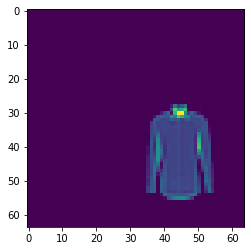

In [ ]:
plt.imshow(fashion_batch[0].cpu().detach().numpy().squeeze())

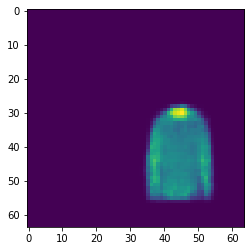

In [ ]:
plt.imshow(rec_img[0].cpu().detach().numpy().squeeze())

## Latent Masking VAE

### Train

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
lam=.2
gamma=10
lr=6e-4
latents=8
C=0
epochs = 30 #30 for movign fashion, 20 for mnist (change to 64x64), 30 for moving mnist
model_save_steps = 2500 #save model after this many "training steps"? (batchs, ~once every 2.5 epochs
exp_name = 'latent_mask_fashion'
steps_per_save = 2500

In [ ]:
save_dir = os.path.join(PARAM_PATH, exp_name + dt.now().strftime('%m_%d_%y_%H_%M_%S'))
os.mkdir(save_dir)

In [ ]:
masked_vae = LatentMaskVAE(encoder=Encoder, decoder=Decoder, latents=latents, device=device, lam=lam) #VanillaVAE(latents=latents)
masked_vae.to(device)
optimizer = torch.optim.Adam(params = masked_vae.parameters(), lr=lr)

In [ ]:
if not train:
    epochs=0

In [ ]:
steps = 0
for epoch in range(epochs):
    total_loss = 0
    total_rec_loss = 0
    total_div_loss = 0
    for X, _y, _pos in fashion_loader:
        X = X.to(device)
        optimizer.zero_grad()

        rec_X, mu, logvar = masked_vae(X)

        rec_loss = reconstruction_loss(X, rec_X)
        kl_loss = kl_div_target(mu, logvar, C=C, gamma=gamma)
        loss = rec_loss + kl_loss

        loss.backward()
        optimizer.step()
        total_loss += loss
        total_rec_loss += rec_loss
        total_div_loss += kl_loss
        
        #save model for training regression and classification 
        if steps % steps_per_save == 0:
            torch.save(masked_vae.state_dict(), os.path.join(save_dir, f"step_{steps}"))

        steps += 1
    print(f"epoch: {epoch}, loss={total_loss/batch_size}, rec_loss={total_rec_loss/batch_size}, total_div_loss={total_div_loss/batch_size}")

In [ ]:
if train:
    torch.save(masked_vae.state_dict(), os.path.join(save_dir, "final"))
    state_dict = torch.load(os.path.join(save_dir, "final"), map_location=torch.device(device))
else:
    state_dict = torch.load(os.path.join(PARAM_PATH+"/latent_mask_mnist04_27_22_12_17_50", "step_27500"), map_location=torch.device(device))


masked_vae.load_state_dict(state_dict=state_dict)
masked_vae.eval()

RuntimeError: Error(s) in loading state_dict for LatentMaskVAE:
	Missing key(s) in state_dict: "encoder.conv1.weight", "encoder.conv1.bias", "encoder.conv2.weight", "encoder.conv2.bias", "encoder.conv3.weight", "encoder.conv3.bias", "encoder.conv4.weight", "encoder.conv4.bias", "encoder.linear.weight", "encoder.linear.bias", "decoder.conv4.weight", "decoder.conv4.bias", "decoder.conv3.weight", "decoder.conv3.bias", "decoder.conv2.weight", "decoder.conv2.bias", "decoder.conv1.weight", "decoder.conv1.bias". 
	Unexpected key(s) in state_dict: "encoder.linear1.weight", "encoder.linear1.bias". 
	size mismatch for encoder.linear_mu.weight: copying a param with shape torch.Size([8, 50]) from checkpoint, the shape in current model is torch.Size([8, 256]).
	size mismatch for encoder.linear_logvar.weight: copying a param with shape torch.Size([8, 50]) from checkpoint, the shape in current model is torch.Size([8, 256]).
	size mismatch for decoder.linear2.weight: copying a param with shape torch.Size([784, 50]) from checkpoint, the shape in current model is torch.Size([256, 8]).
	size mismatch for decoder.linear2.bias: copying a param with shape torch.Size([784]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for decoder.linear1.weight: copying a param with shape torch.Size([50, 8]) from checkpoint, the shape in current model is torch.Size([2048, 256]).
	size mismatch for decoder.linear1.bias: copying a param with shape torch.Size([50]) from checkpoint, the shape in current model is torch.Size([2048]).

In [ ]:
with torch.no_grad():
    rec_img, _mu, _logvar = masked_vae(fashion_batch)

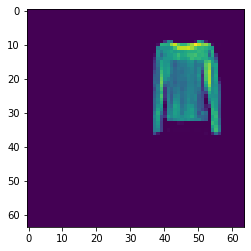

In [ ]:
plt.imshow(fashion_batch[0].detach().numpy().squeeze())

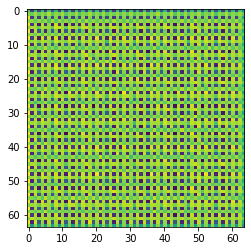

In [ ]:
plt.imshow(rec_img[0].detach().numpy().squeeze())

## Environmental Inference

In [ ]:
#NOTE: I think the reconstruction loss stuff has bugs, (or I should run it for more iterations, or there's a thing where anomolus rec loss gets put in different env, and then the next env adopts that as its env, which is just a flaw in the system or something)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
small_fashion = CommonFashionMNIST(DATA_PATH, transform=ToTensor())
sf_loader = DataLoader(small_fashion, batch_size=batch_size, shuffle=True)

In [ ]:
lam=2
kappa=1.5
gamma=10
lr=6e-4
latents=8
max_envs = 7
C=0
epochs = 10 #30 for movign fashion, 20 for mnist (change to 64x64), 30 for moving mnist
model_save_steps = 2500 #save model after this many "training steps"? (batchs, ~once every 2.5 epochs
exp_name = 'env_infer_small'
steps_per_save = 2500

In [ ]:
save_dir = os.path.join(PARAM_PATH, exp_name + dt.now().strftime('%m_%d_%y_%H_%M_%S'))
os.mkdir(save_dir)

In [ ]:
envinfer_vae = EnvInferVAE(encoder=FCEncoder, decoder=FCDecoder, latents=latents, max_envs=max_envs, lam=lam, kappa=kappa, device=device) #VanillaVAE(latents=latents)
envinfer_vae.to(device)
optimizer = torch.optim.Adam(params = envinfer_vae.parameters(), lr=lr)

In [ ]:
steps = 0
for epoch in range(epochs):
    total_loss = 0
    total_rec_loss = 0
    total_div_loss = 0
    for X, _y in mnist_loader:
        X = X.to(device)
        optimizer.zero_grad()

        rec_X, mu, logvar, env_idx, z = envinfer_vae(X)

        rec_loss = reconstruction_loss(X, rec_X)
        kl_loss = kl_div_target(mu, logvar, C=C, gamma=gamma)
        loss = rec_loss + kl_loss

        loss.backward()
        optimizer.step()
        total_loss += loss
        total_rec_loss += rec_loss
        total_div_loss += kl_loss
        
        #save model for training regression and classification 
        if steps % steps_per_save == 0:
            torch.save(envinfer_vae.state_dict(), os.path.join(save_dir, f"mnist_step_{steps}"))

        steps += 1
    print(f"epoch: {epoch}, loss={total_loss/batch_size}, rec_loss={total_rec_loss/batch_size}, total_div_loss={total_div_loss/batch_size}, last_env={env_idx}")

epoch: 0, loss=3565.50537109375, rec_loss=3406.205810546875, total_div_loss=159.2944793701172, last_env=0


KeyboardInterrupt: 

In [ ]:
steps = 0
for epoch in range(epochs):
    total_loss = 0
    total_rec_loss = 0
    total_div_loss = 0
    for X, _y in sf_loader:
        X = X.to(device)
        optimizer.zero_grad()

        rec_X, mu, logvar, env_idx, z = envinfer_vae(X)

        rec_loss = reconstruction_loss(X, rec_X)
        kl_loss = kl_div_target(mu, logvar, C=C, gamma=gamma)
        loss = rec_loss + kl_loss

        loss.backward()
        optimizer.step()
        total_loss += loss
        total_rec_loss += rec_loss
        total_div_loss += kl_loss
        
        #save model for training regression and classification 
        if steps % steps_per_save == 0:
            torch.save(masked_vae.state_dict(), os.path.join(save_dir, f"fashion_step_{steps}"))

        steps += 1
    print(f"epoch: {epoch}, loss={total_loss/batch_size}, rec_loss={total_rec_loss/batch_size}, total_div_loss={total_div_loss/batch_size}, last_env={env_idx}")

New environment: anomolous reconstruction loss
epoch: 0, loss=5029.16943359375, rec_loss=4721.36962890625, total_div_loss=307.7991943359375, last_env=1


KeyboardInterrupt: 

In [ ]:
envinfer_vae.latent_masks

NameError: name 'envinfer_vae' is not defined

In [ ]:
with torch.no_grad():
    rec_img, _mu, _logvar, _envidx, _z = envinfer_vae(sf_batch)

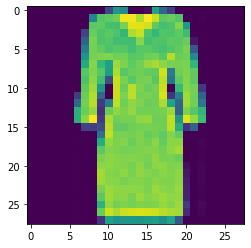

In [ ]:
plt.imshow(sf_batch[0].to('cpu').detach().numpy().squeeze())

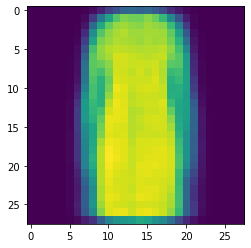

In [ ]:
plt.imshow(rec_img[0].to('cpu').detach().numpy().squeeze())

In [ ]:
with torch.no_grad():
    rec_img, _mu, _logvar, _envidx, _z = envinfer_vae(mnist_batch)

In [ ]:
_envidx

tensor(1)

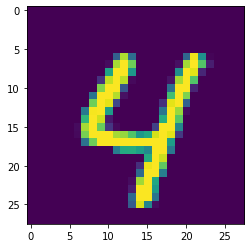

In [ ]:
plt.imshow(mnist_batch[3].to('cpu').detach().numpy().squeeze())

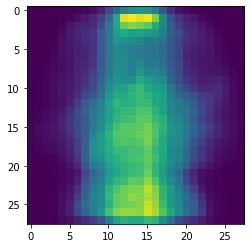

In [ ]:
plt.imshow(rec_img[3].to('cpu').detach().numpy().squeeze())

In [ ]:
#TODO: see what happens when you change the environment to 6, more fashion-y?

In [ ]:
with torch.no_grad():
    mu, _logvar, _final = envinfer_vae.encoder(mnist_batch)
    env_idx = 1
    s = torch.ones(batch_size, dtype=torch.int64) * env_idx
    rec_img = envinfer_vae.decoder(mu, s)

NameError: name 'torch' is not defined

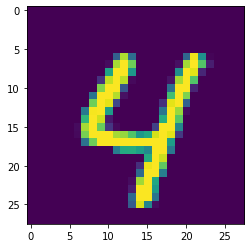

In [ ]:
plt.imshow(mnist_batch[3].to('cpu').detach().numpy().squeeze())

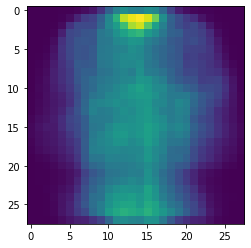

In [ ]:
plt.imshow(rec_img[3].to('cpu').detach().numpy().squeeze())

In [ ]:
#hyper params
#optimizer
#dataset
#model
#training loop

## Generative Replay

To prevent catastrophic forgetting, the paper uses generative replay, sampling from the previous verion of the model, and penalizing distances between the old and new latent representations and reconstructions of this sample.

More formally, we have parameter snapshots $$\phi_{old}, \theta_{old}$$ from which we sample $x_{old} \sim q_{\theta_{old}}(\cdot|z, s_{old})$, sampling $z$ from the prior. (I think without the latent mask because no s superscript - see generative process). With $x_{old}$, we compute the following loss:

$$ \mathcal{L}_{past}(\phi, \theta) = E_{z, s', x'}[D(q_{\phi}(D[q_{\phi}(z|x'), q_{\phi}'(z'|x')] + D[q_{\theta}(x|z,s'), q_{\theta'}(x'|z, s')]))]$$

Where the first D is the [Wasserstein distance](https://en.wikipedia.org/wiki/Wasserstein_metric) and the second in the [KL Divergence between two Bernoullis](https://math.stackexchange.com/questions/2604566/kl-divergence-between-two-multivariate-bernoulli-distribution)

The parameters $\phi_{old}, \theta_{old}$ get synced with the current network every $\tau$ steps, with $\tau$ a hyper parameter

### Encoder Proximity

The first part of the loss function is the encoder proximity: 
$$E_{z, s', x'}[D(q_{\phi}(D[q_{\phi}(z|x'), q_{\phi}'(z'|x')]]$$

With D the Wasserstein distance. But what _is_ the Wassertein distance..

[See here](https://dfdazac.github.io/sinkhorn.html) for explanation - but with diagonal gaussians, the Wassertein distance just reduces to the Euclidean distance:
$$D(q_{\phi}(D[q_{\phi}(z|x'), q_{\phi'}(z'|x')] = ||(q_{\phi}(z|x') - q_{\phi'}(z'|x'))||^2_2$$


In [ ]:
#export
def encoder_proximity(z, z_old):
    return torch.mean(euclidean(z, z_old))

In [ ]:
assert encoder_proximity(mu, mu).shape == torch.Size([])

### Decoder Proximity 

$$D[q_{\theta}(x|z,s'), q_{\theta'}(x'|z, s')])$$ 

Here D is the KL Divergence between the reconstructions (which are HxW independant Bernoullis). Since $\theta_{old}$ is fixed, this is equivalent to minimizing the cross entropy loss

In [ ]:
#export
def decoder_proximity(x, x_old):
    return torch.mean(rec_likelihood(x, x_old))

In [ ]:
assert decoder_proximity(mnist_batch, rec).shape == torch.Size([])

### Train

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

NOTE: I wonder if the whole $alpha < \lambda_1 -> \alpha=0$ prevents these degenerate cases - maybe masking unused ones does to....

In [ ]:
alpha=1
beta=1
tau=5000
sample_batch_size = batch_size * 2
lam=100
kappa=3
gamma=10
lr=6e-4
latents=8
max_envs = 7
C=0
epochs = 10 #30 for movign fashion, 20 for mnist (change to 64x64), 30 for moving mnist
model_save_steps = 2500 #save model after this many "training steps"? (batchs, ~once every 2.5 epochs
exp_name = 'gen_replay_small'
steps_per_save = 2500

In [ ]:
save_dir = os.path.join(PARAM_PATH, exp_name + dt.now().strftime('%m_%d_%y_%H_%M_%S'))
os.mkdir(save_dir)

In [ ]:
gen_vae = GenReplayVAE(FCEncoder, FCDecoder, latents, max_envs, lam, kappa, tau, device)
optimizer = torch.optim.Adam(params = gen_vae.model.parameters(), lr=lr, eps=1e-4)

bug happens immediately after _second_ parameter update...

In [ ]:
steps = 0
for epoch in range(epochs):
    total_loss = 0
    total_rec_loss = 0
    total_div_loss = 0
    total_encode_loss = 0
    total_decode_loss = 0
    for X, _y in mnist_loader:
        X = X.to(device)
        optimizer.zero_grad()

        #forward pass on current batch
        rec_X, mu, logvar, env_idx, z = gen_vae(X)
        rec_loss = reconstruction_loss(X, rec_X)
        kl_loss = kl_div_target(mu, logvar, C=C, gamma=gamma)
        cur_loss = rec_loss + kl_loss

        #generate halucinated data
        X_h = gen_vae.sample(sample_batch_size)

        #forward pass on imagined samples
        rec_X_h, old_rec_X_h, z, old_z = gen_vae.forward_halu(X_h)
        encode_loss = alpha * encoder_proximity(z, old_z)
        decode_loss = beta * decoder_proximity(rec_X_h, old_rec_X_h)
        replay_loss = encode_loss + decode_loss

        #backward pass
        loss = cur_loss + replay_loss
        loss.backward()
        optimizer.step()
        total_loss += loss
        total_rec_loss += rec_loss
        total_div_loss += kl_loss
        total_encode_loss += encode_loss
        total_decode_loss += decode_loss
        
        #save model for training regression and classification 
        if steps % steps_per_save == 0:
            torch.save(gen_vae.state_dict(), os.path.join(save_dir, f"mnist_step_{steps}"))

        steps += 1
    print(f"epoch: {epoch}, loss={total_loss/batch_size}, rec_loss={total_rec_loss/batch_size}, total_div_loss={total_div_loss/batch_size}, encode_loss={total_encode_loss}, decode_loss={total_decode_loss}, last_env={env_idx}")

epoch: 0, loss=11364.966796875, rec_loss=3422.363037109375, total_div_loss=187.06246948242188, encode_loss=3362.549072265625, decode_loss=492991.5625, last_env=0
epoch: 1, loss=10475.7490234375, rec_loss=2812.869873046875, total_div_loss=167.5354766845703, encode_loss=4924.357421875, decode_loss=474777.6875, last_env=0
epoch: 2, loss=10383.130859375, rec_loss=2653.090087890625, total_div_loss=253.99563598632812, encode_loss=4264.94580078125, decode_loss=474201.4375, last_env=0
epoch: 3, loss=10318.6015625, rec_loss=2541.29541015625, total_div_loss=313.8886413574219, encode_loss=3730.681396484375, decode_loss=473927.25, last_env=0
epoch: 4, loss=10279.638671875, rec_loss=2484.191162109375, total_div_loss=340.6321716308594, encode_loss=3356.17431640625, decode_loss=473752.65625, last_env=0
epoch: 5, loss=6832.9189453125, rec_loss=2444.7294921875, total_div_loss=465.66558837890625, encode_loss=2307.84814453125, decode_loss=248733.890625, last_env=0
epoch: 6, loss=4976.80126953125, rec_los

In [ ]:
steps = 0
for epoch in range(epochs):
    total_loss = 0
    total_rec_loss = 0
    total_div_loss = 0
    total_encode_loss = 0
    total_decode_loss = 0
    for X, _y in sf_loader:
        X = X.to(device)
        optimizer.zero_grad()

        #forward pass on current batch
        rec_X, mu, logvar, env_idx, z = gen_vae(X)
        rec_loss = reconstruction_loss(X, rec_X)
        kl_loss = kl_div_target(mu, logvar, C=C, gamma=gamma)
        cur_loss = rec_loss + kl_loss

        #generate halucinated data
        X_h = gen_vae.sample(sample_batch_size)

        #forward pass on imagined samples
        rec_X_h, old_rec_X_h, z, old_z = gen_vae.forward_halu(X_h)
        encode_loss = alpha * encoder_proximity(z, old_z)
        decode_loss = beta * decoder_proximity(rec_X_h, old_rec_X_h)
        replay_loss = encode_loss + decode_loss

        #backward pass
        loss = cur_loss + replay_loss
        loss.backward()
        optimizer.step()
        total_loss += loss
        total_rec_loss += rec_loss
        total_div_loss += kl_loss
        total_encode_loss += encode_loss
        total_decode_loss += decode_loss
        
        #save model for training regression and classification 
        if steps % steps_per_save == 0:
            torch.save(gen_vae.state_dict(), os.path.join(save_dir, f"mnist_step_{steps}"))

        steps += 1
    print(f"epoch: {epoch}, loss={total_loss/batch_size}, rec_loss={total_rec_loss/batch_size}, total_div_loss={total_div_loss/batch_size}, encode_loss={total_encode_loss}, decode_loss={total_decode_loss}, last_env={env_idx}")

New environment: anomolous reconstruction loss
epoch: 0, loss=7248.33544921875, rec_loss=4847.71435546875, total_div_loss=675.9827880859375, encode_loss=2595.0068359375, decode_loss=107782.3046875, last_env=1
epoch: 1, loss=5878.02734375, rec_loss=4213.63818359375, total_div_loss=597.3408813476562, encode_loss=2332.27978515625, decode_loss=65958.828125, last_env=1
epoch: 2, loss=5697.8525390625, rec_loss=4094.260498046875, total_div_loss=575.869873046875, encode_loss=2714.385498046875, decode_loss=63060.00390625, last_env=1
epoch: 3, loss=5606.8212890625, rec_loss=4034.160888671875, total_div_loss=567.8511352539062, encode_loss=2862.005615234375, decode_loss=61445.8046875, last_env=1
epoch: 4, loss=5554.13671875, rec_loss=3999.262451171875, total_div_loss=563.2952880859375, encode_loss=2902.9326171875, decode_loss=60558.07421875, last_env=1


RuntimeError: all elements of input should be between 0 and 1

In [ ]:
with torch.no_grad():
    rec_img, _mu, _logvar, _envidx, _z = gen_vae(mnist_batch)

In [ ]:
_envidx

tensor(3)

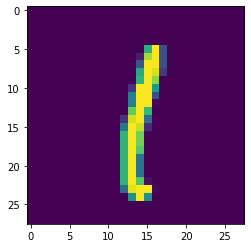

In [ ]:
plt.imshow(mnist_batch[1].to('cpu').detach().numpy().squeeze())

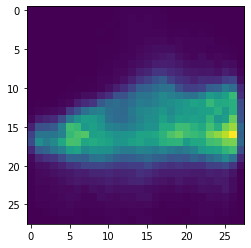

In [ ]:
plt.imshow(rec_img[1].to('cpu').detach().numpy().squeeze())

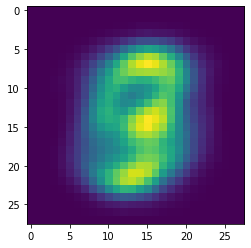

In [ ]:
plt.imshow(rec_img[0].to('cpu').detach().numpy().squeeze())

## Classification and Regression